In [73]:
import torch

# 1. 버전 확인
print(f"Torch Version: {torch.__version__}")

# 2. GPU 인식 여부 (True가 나와야 성공)
print(f"CUDA Available: {torch.cuda.is_available()}")

# 3. GPU 이름 출력
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

Torch Version: 2.10.0+cu130
CUDA Available: True
Device Name: NVIDIA GeForce RTX 5060


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

import torch
torch.set_float32_matmul_precision('high')
import gc
import lightning.pytorch as pl

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting.metrics import MAE, SMAPE, RMSE

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [75]:
data = pd.read_csv('sales_data.csv')
data.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


In [76]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                76000 non-null  object 
 1   Store ID            76000 non-null  object 
 2   Product ID          76000 non-null  object 
 3   Category            76000 non-null  object 
 4   Region              76000 non-null  object 
 5   Inventory Level     76000 non-null  int64  
 6   Units Sold          76000 non-null  int64  
 7   Units Ordered       76000 non-null  int64  
 8   Price               76000 non-null  float64
 9   Discount            76000 non-null  int64  
 10  Weather Condition   76000 non-null  object 
 11  Promotion           76000 non-null  int64  
 12  Competitor Pricing  76000 non-null  float64
 13  Seasonality         76000 non-null  object 
 14  Epidemic            76000 non-null  int64  
 15  Demand              76000 non-null  int64  
dtypes: f

In [77]:
# Show statistical summary of numerical features
data.describe()

,Inventory Level,Units Sold,Units Ordered,Price,Discount,Promotion,Competitor Pricing,Epidemic,Demand
count,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000
mean,301.062842,88.827316,89.090645,67.726028,9.087039,0.328947,69.454029,0.200000,104.317158
std,226.510161,43.994525,162.404627,39.377899,7.475781,0.469834,40.943818,0.400003,46.964801
min,0.000000,0.000000,0.000000,4.740000,0.000000,0.000000,4.290000,0.000000,4.000000
25%,136.000000,58.000000,0.000000,31.997500,5.000000,0.000000,32.620000,0.000000,71.000000
50%,227.000000,84.000000,0.000000,64.500000,10.000000,0.000000,65.700000,0.000000,100.000000
75%,408.000000,114.000000,121.000000,95.830000,10.000000,1.000000,97.932500,0.000000,133.000000
max,2267.000000,426.000000,1616.000000,228.030000,25.000000,1.000000,261.220000,1.000000,430.000000


In [78]:
# Convert 'Date' column to datetime and sort the data
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by=['Store ID', 'Product ID', 'Date'])
data.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
100,2022-01-02,S001,P0001,Electronics,North,93,71,0,65.63,5,Snowy,0,73.66,Winter,0,84
200,2022-01-03,S001,P0001,Electronics,North,274,142,229,68.55,15,Snowy,1,80.73,Winter,0,132
300,2022-01-04,S001,P0001,Electronics,North,132,42,0,61.66,10,Snowy,0,54.88,Winter,0,67
400,2022-01-05,S001,P0001,Electronics,North,319,129,0,59.56,25,Snowy,1,57.34,Winter,0,110


# EDA

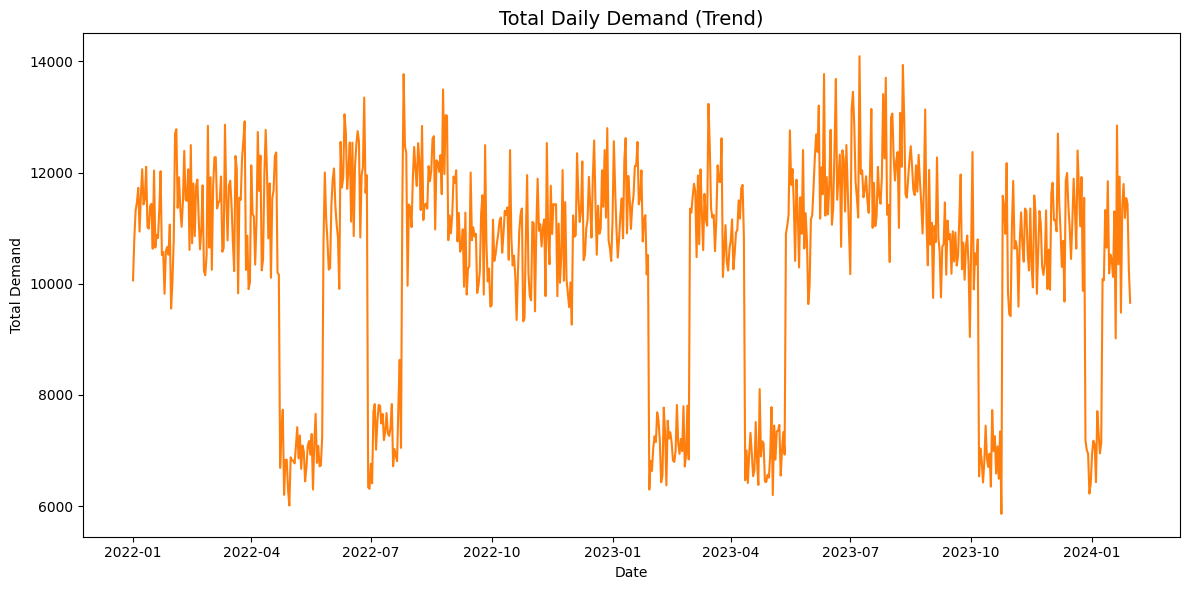

In [79]:
# Visualize total daily demand to identify trends 

daily_demand = data.groupby('Date')['Demand'].sum().reset_index()


plt.figure(figsize=(12, 6))
plt.plot(daily_demand['Date'], daily_demand['Demand'], color='tab:orange')
plt.title('Total Daily Demand (Trend)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Demand')

plt.tight_layout()
plt.show()

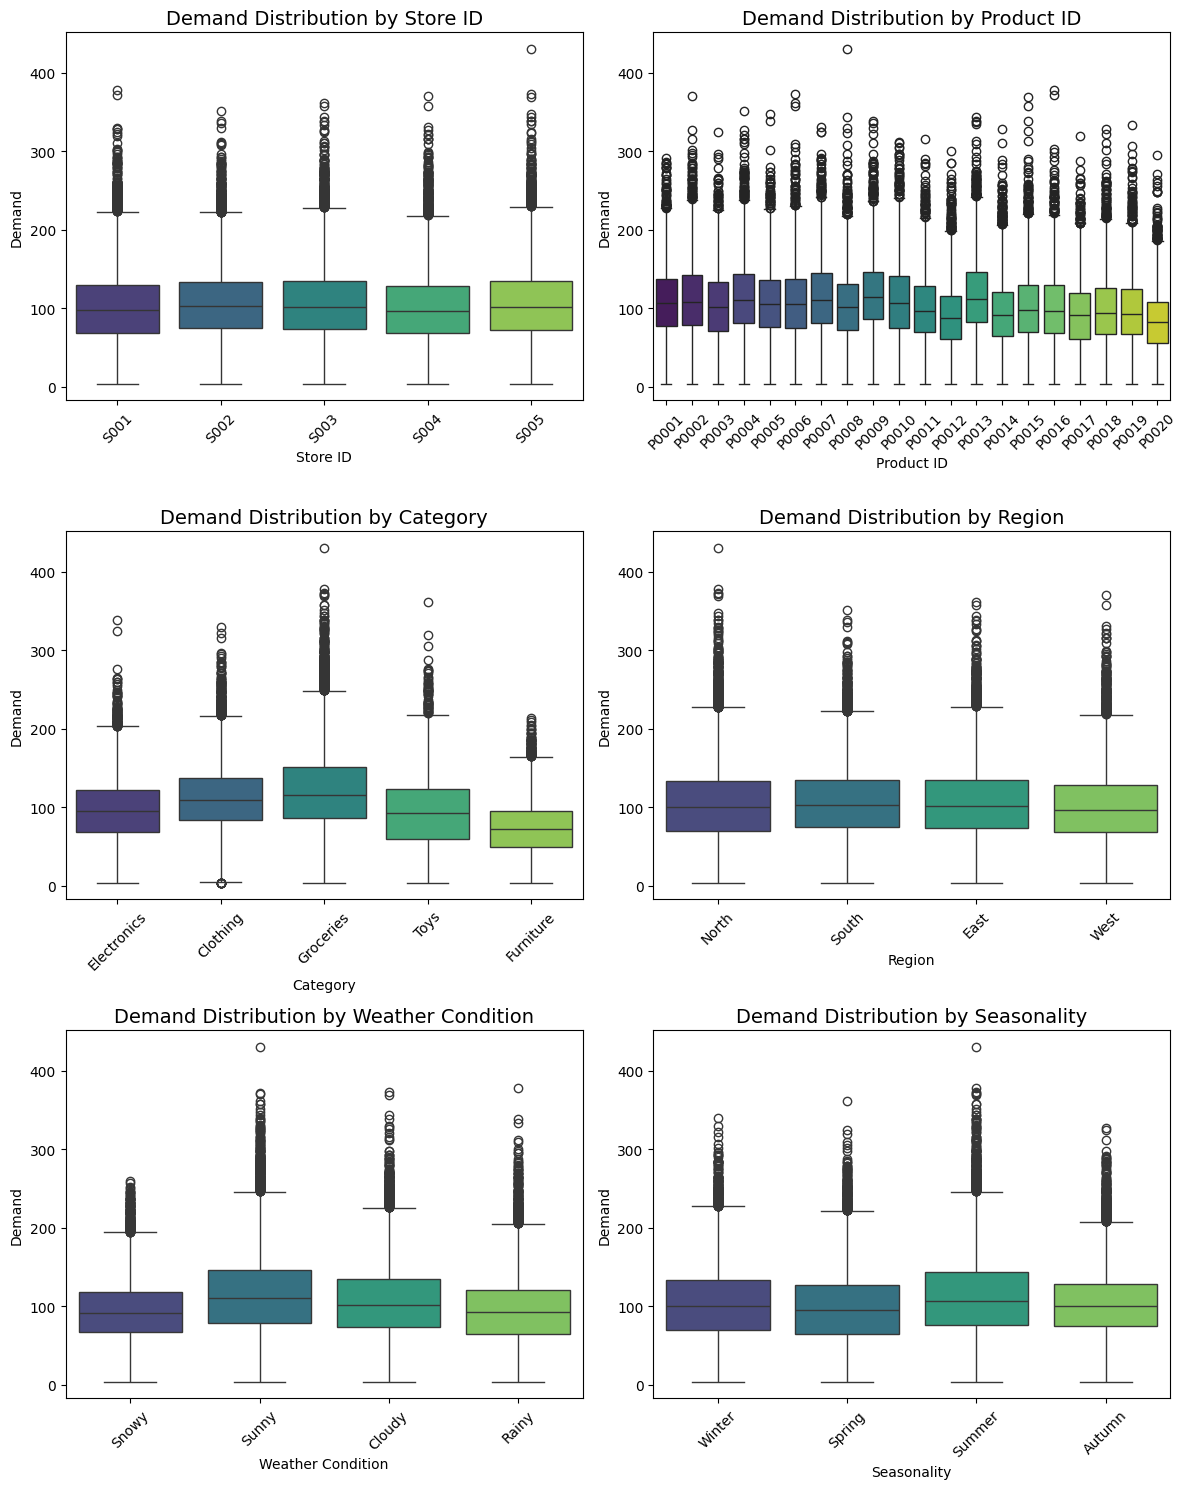

In [80]:
# Visualize categorical feature distributions with respect to Demand

n_features = data.select_dtypes(include=['object']).columns.tolist()
n_cols = 2
n_rows = math.ceil(len(n_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(n_features):
    sns.boxplot(data=data, x=feature, y='Demand', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Demand Distribution by {feature}', fontsize=14)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Demand')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
                        

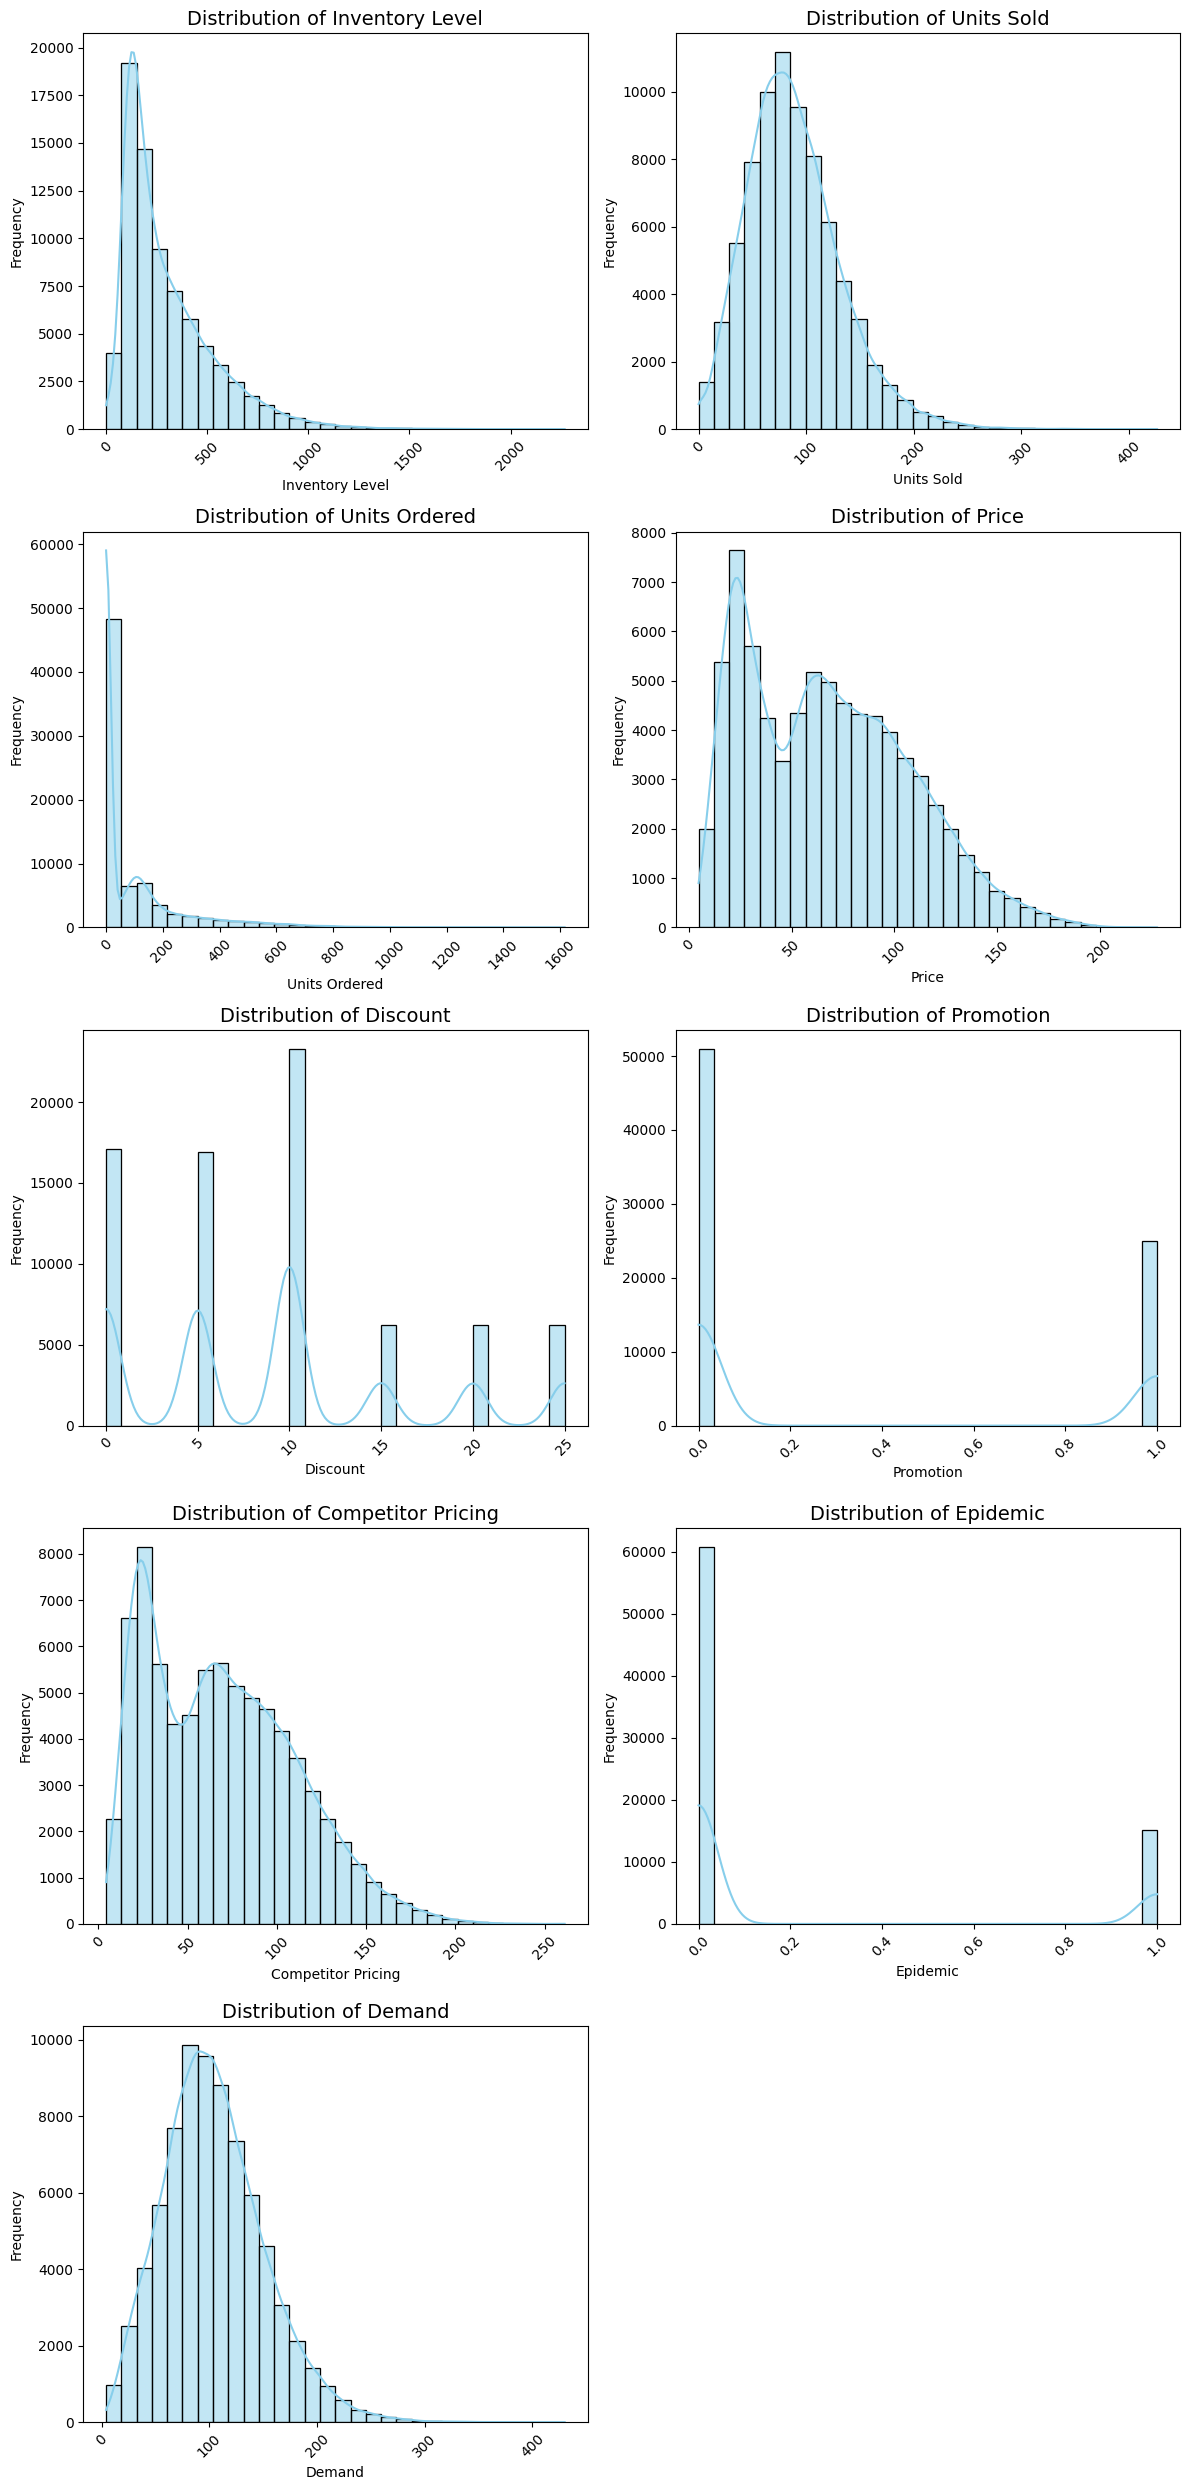

In [81]:
# Visualize numerical feature distributions

n_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
n_cols = 2
n_rows = math.ceil(len(n_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(n_features):
    sns.histplot(data[feature], kde=True, bins=30, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

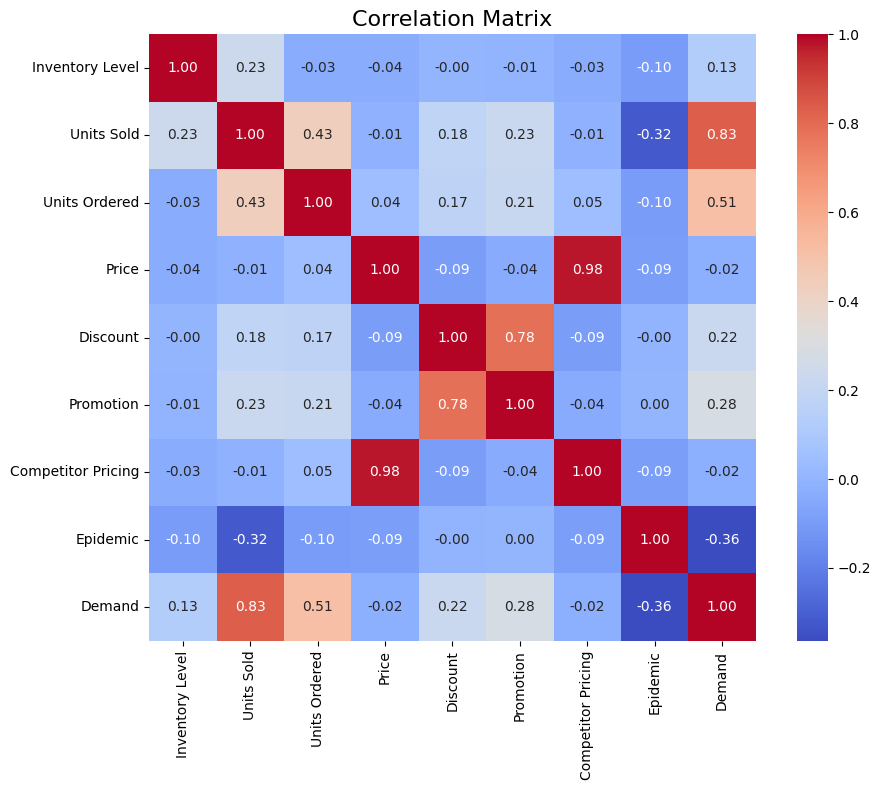

In [82]:
# Correlation matrix heatmap

corr = data.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

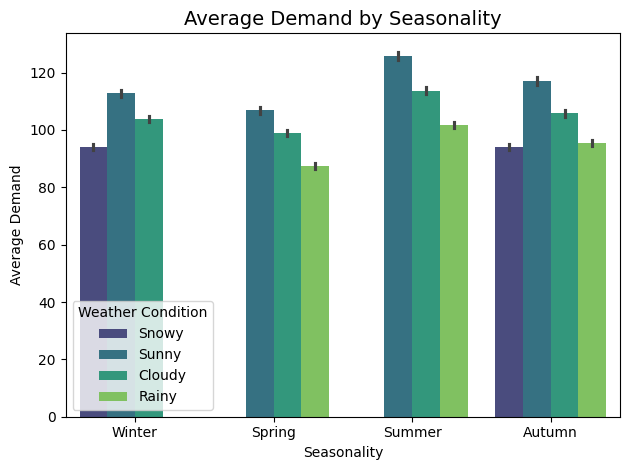

In [83]:
# Visualize Demand by Seasonality and Weather Condition

sns.barplot(data=data, x='Seasonality', y='Demand', hue='Weather Condition', palette='viridis')
plt.title('Average Demand by Seasonality', fontsize=14)
plt.xlabel('Seasonality')
plt.ylabel('Average Demand')
plt.tight_layout()
plt.show()

In [84]:
# Calculate and print stockout rate

stockouts = data[data['Demand'] > data['Inventory Level']]
stockout_rate = len(stockouts) / len(data) * 100
print(f'Stockout Rate: {stockout_rate:.2f}%')

Stockout Rate: 13.68%


# Feature Engineering

In [85]:
def feature_engineering(df):
    data = df.copy()

    # Date features
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month.astype(str)   
    data['DayOfWeek'] = data['Date'].dt.dayofweek.astype(str)
    data['IsWeekend'] = (data['Date'].dt.dayofweek >= 5).astype(str)

    # Time index feature    
    data['time_idx'] = (data['Date'] - data['Date'].min()).dt.days

    # Price ratio feature  
    data['Price_Ratio'] = data['Price'] / data['Competitor Pricing']

    # Price segment feature
    data['Price_Segment'] = data['Price'].apply(lambda x: 'Low' if x < 50 else 'High')

    return data

In [86]:
def preprocessing_data(df):
    # Feature engineering
    data = feature_engineering(df)
    
    # Sort data by Store ID, Product ID, and Date
    data = data.sort_values(['Store ID', 'Product ID', 'Date']).reset_index(drop=True)

    # Convert categorical columns to string type 
    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        data[col] = data[col].astype(str)
    
    # Convert categorical columns to string type
    data['Promotion'] = data['Promotion'].astype(str)
    data['Epidemic'] = data['Epidemic'].astype(str)
    
    # Convert numerical columns to float type
    data['Demand'] = data['Demand'].astype(float)
    data['Units Sold'] = data['Units Sold'].astype(float)
    data['Discount'] = data['Discount'].astype(float)
    data['Year'] = data['Year'].astype(float)
    
    # Log transformation for skewed numerical features
    data['Inventory Level'] = np.log1p(data['Inventory Level']) 
    data['Units Ordered'] = np.log1p(data['Units Ordered'])

    return data

In [87]:
# Preprocessing TFT data
print("TFT data preprocessing completed")
data_preprocessed = preprocessing_data(data)
data_preprocessed.head()

TFT data preprocessing completed


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,...,Seasonality,Epidemic,Demand,Year,Month,DayOfWeek,IsWeekend,time_idx,Price_Ratio,Price_Segment
0,2022-01-01,S001,P0001,Electronics,North,5.278115,102.0,5.533389,72.72,5.0,...,Winter,0,115.0,2022.0,1,5,True,0,0.848244,High
1,2022-01-02,S001,P0001,Electronics,North,4.543295,71.0,0.000000,65.63,5.0,...,Winter,0,84.0,2022.0,1,6,True,1,0.890986,High
2,2022-01-03,S001,P0001,Electronics,North,5.616771,142.0,5.438079,68.55,15.0,...,Winter,0,132.0,2022.0,1,0,False,2,0.849127,High
3,2022-01-04,S001,P0001,Electronics,North,4.890349,42.0,0.000000,61.66,10.0,...,Winter,0,67.0,2022.0,1,1,False,3,1.123542,High
4,2022-01-05,S001,P0001,Electronics,North,5.768321,129.0,0.000000,59.56,25.0,...,Winter,0,110.0,2022.0,1,2,False,4,1.038716,High


In [88]:
# Use 90 units of past data to predict 30 units of future data
max_prediction_length = 30
max_encoder_length = 90

# Calculate the point where training data ends to reserve the last window for validation
training_cutoff = data_preprocessed['time_idx'].max() - max_prediction_length

# Create the Training DataSet
training = TimeSeriesDataSet(
    # Only use data up to the cutoff point for training
    data_preprocessed[data_preprocessed.time_idx <= training_cutoff],

    time_idx='time_idx',
    target='Demand',
    
    # Unique identifiers for each time series (Entity grouping)
    group_ids=['Store ID', 'Product ID'],

    # Encoder: The 'Look-back' window (Past data)
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,

    # Prediction: The 'Look-ahead' window (Future data)
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,

    # Variables that do not change over time
    static_categoricals=["Store ID", "Product ID", "Category", "Region"],

    # Known future variables
    time_varying_known_categoricals=["Seasonality", "DayOfWeek", "IsWeekend", "Price_Segment", "Promotion"],
    time_varying_known_reals=["time_idx", "Price", "Discount"],

    # Unknown future variables
    time_varying_unknown_categoricals=["Weather Condition", "Epidemic"],
    time_varying_unknown_reals=["Demand", "Inventory Level", "Units Sold", "Units Ordered", "Price_Ratio", "Competitor Pricing"], 

    # Normalize the target based on its group to handle different scales
    target_normalizer=GroupNormalizer(groups=["Store ID", "Product ID"], transformation="softplus"),

    # Feature engineering flags for the model
    add_relative_time_idx=True,     # Adds a relative time index
    add_target_scales=True,         # Feature engineering flags for the model
    add_encoder_length=True,        # Lets the model know how much history it is seeing
    allow_missing_timesteps=True,   # Handles gaps in the time sequence
)

# Create the Validation Dataset using the same parameters as the training set
validation = TimeSeriesDataSet.from_dataset(training, data_preprocessed, predict=True, stop_randomization=True)

# Convert datasets into Dataloaders for batch processing
batch_size = 512
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [89]:
# Drop rows with NaN values
data_preprocessed = data_preprocessed.dropna() 

# Convert categorical columns to string type
for col in data_preprocessed.select_dtypes(include=['object']).columns:
    data_preprocessed[col] = data_preprocessed[col].astype(str)

# Check for negative values in the target variable (Demand) and filter them out
if data_preprocessed['Demand'].min() < 0:
    print("Wnaring: Demand < 0 values found! These will be removed.")
    data_preprocessed = data_preprocessed[data_preprocessed['Demand'] >= 0]

In [90]:
def objective(trial):

    # Clear GPU cache
    gc.collect()
    torch.cuda.empty_cache()

    # Hyperparameter suggestions
    hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64])
    dropout = trial.suggest_float("dropout", 0.1, 0.4)
    hidden_continuous_size = trial.suggest_categorical("hidden_continuous_size", [8, 16, 32])
    attention_head_size = trial.suggest_categorical("attention_head_size", [1, 2, 4])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # Initialize Temporal Fusion Transformer model with suggested hyperparameters
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        hidden_continuous_size=hidden_continuous_size,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )

    # Set up TensorBoard logger for the current trial
    logger = TensorBoardLogger(
        save_dir="lightning_logs",           
        name="optuna_tft",                  
        version=f"trial_{trial.number}",     
        default_hp_metric=True               
    )

    # Set up Optuna pruning callback to stop unpromising trials early
    pruning_callback = PyTorchLightningPruningCallback(trial, monitor="val_loss")

    # Set up model checkpointing to save the best model based on validation loss
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        dirpath=f"saved_models/trial_{trial.number}",
        filename="best-checkpoint",
        save_top_k=1  
    )
    
    # Set up early stopping to prevent overfitting and save training time
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,  
        verbose=False,
        mode="min"
    )

    # Set random seed
    pl.seed_everything(42)

    # Initialize PyTorch Lightning Trainer with callbacks and logger
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="gpu",
        devices=1,
        # precision="16", 
        gradient_clip_val=0.1,
        callbacks=[pruning_callback, checkpoint_callback, early_stop_callback],
        enable_progress_bar=True,
        enable_model_summary=False,
        logger=logger,
    )

    # Train the model and return the best validation loss for Optuna to optimize
    print("🚀 Start TFT Learning...")
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    return trainer.callback_metrics["val_loss"].item()

In [91]:
# Run Optuna study to optimize hyperparameters based on validation loss
study = optuna.create_study(direction="minimize", study_name="TFT_Tuning")
study.optimize(objective, n_trials=20)

[I 2026-02-16 17:26:10,801] A new study created in memory with name: TFT_Tuning
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🚀 Start TFT Learning...
Epoch 3:  59%|█████▉    | 88/148 [01:13<00:50,  1.19it/s, v_num=al_0, train_loss_step=9.690, val_loss=8.860, train_loss_epoch=9.950] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

In [ ]:
# Load the best model from the best trial
best_trial_no = 7 
best_model_path = f"saved_models/trial_{best_trial_no}/best-checkpoint.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

print(f"Trial {best_trial_no} model loaded successfully.")
print("Best Hyperparameters:")
print(f"Hidden Size: {best_tft.hparams.hidden_size}")
print(f"Learning Rate: {best_tft.hparams.learning_rate}")
print(f"Dropout: {best_tft.hparams.dropout}")
print(f"Attention Heads: {best_tft.hparams.attention_head_size}")

Trial 7 model loaded successfully.
Best Hyperparameters:
Hidden Size: 64
Learning Rate: 0.008040444263766957
Dropout: 0.2433929223767682
Attention Heads: 2


In [ ]:
# Evaluate the best model on the validation set
raw_predictions, x, *others = best_tft.predict(val_dataloader, mode="raw", return_x=True)
predictions = raw_predictions.prediction
pred_points = predictions[:, :, 3] 

# Extract the actual target values and predicted points for evaluation
actuals = x["decoder_target"]

# Convert tensors to numpy arrays for metric calculations
y_true = actuals.cpu().numpy().flatten() 
y_pred = pred_points.cpu().numpy().flatten()

# Predict baseline values for comparison
baseline = Baseline()
baseline_preds = baseline.predict(val_dataloader)
y_baseline = baseline_preds.cpu().numpy().flatten()


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
# MAPE (Goal: < 10%)
mape_model = mean_absolute_percentage_error(y_true, y_pred)
mape_baseline = mean_absolute_percentage_error(y_true, y_baseline)

# RMSE (Goal: 15% improvement over Baseline)
rmse_model = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_baseline = np.sqrt(mean_squared_error(y_true, y_baseline))

# Calculate percentage improvement in RMSE compared to baseline
improvement = (rmse_baseline - rmse_model) / rmse_baseline * 100 if rmse_baseline != 0 else 0

# Print the final performance report
print(f"Final Performance Evaluation Report")
print("="*50)
print(f"1. MAPE (Goal: < 10%)")
print(f"   - My Model : {mape_model*100:.2f}%")
print(f"   - Baseline : {mape_baseline*100:.2f}%")
if mape_model < 0.10:
    print("   Result: Success! (MAPE < 10%)")
else:
    print("   Result: Failure (MAPE >= 10%) - Further tuning needed")

print("-" * 50)
print(f"RMSE (Goal: 15% improvement over Baseline)")
print(f"   - My Model : {rmse_model:.2f}")
print(f"   - Baseline : {rmse_baseline:.2f}")
print(f"   - Improvement   : {improvement:.2f}%")

if improvement >= 15:
    print("   Result: Success! (15% or more improvement)")
else:
    print("   Result: Failure (Less than 15% improvement)")
print("="*50)

Final Performance Evaluation Report
1. MAPE (Goal: < 10%)
   - My Model : 10.15%
   - Baseline : 54.79%
   Result: Failure (MAPE >= 10%) - Further tuning needed
--------------------------------------------------
RMSE (Goal: 15% improvement over Baseline)
   - My Model : 9.14
   - Baseline : 61.06
   - Improvement   : 85.03%
   Result: Success! (15% or more improvement)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


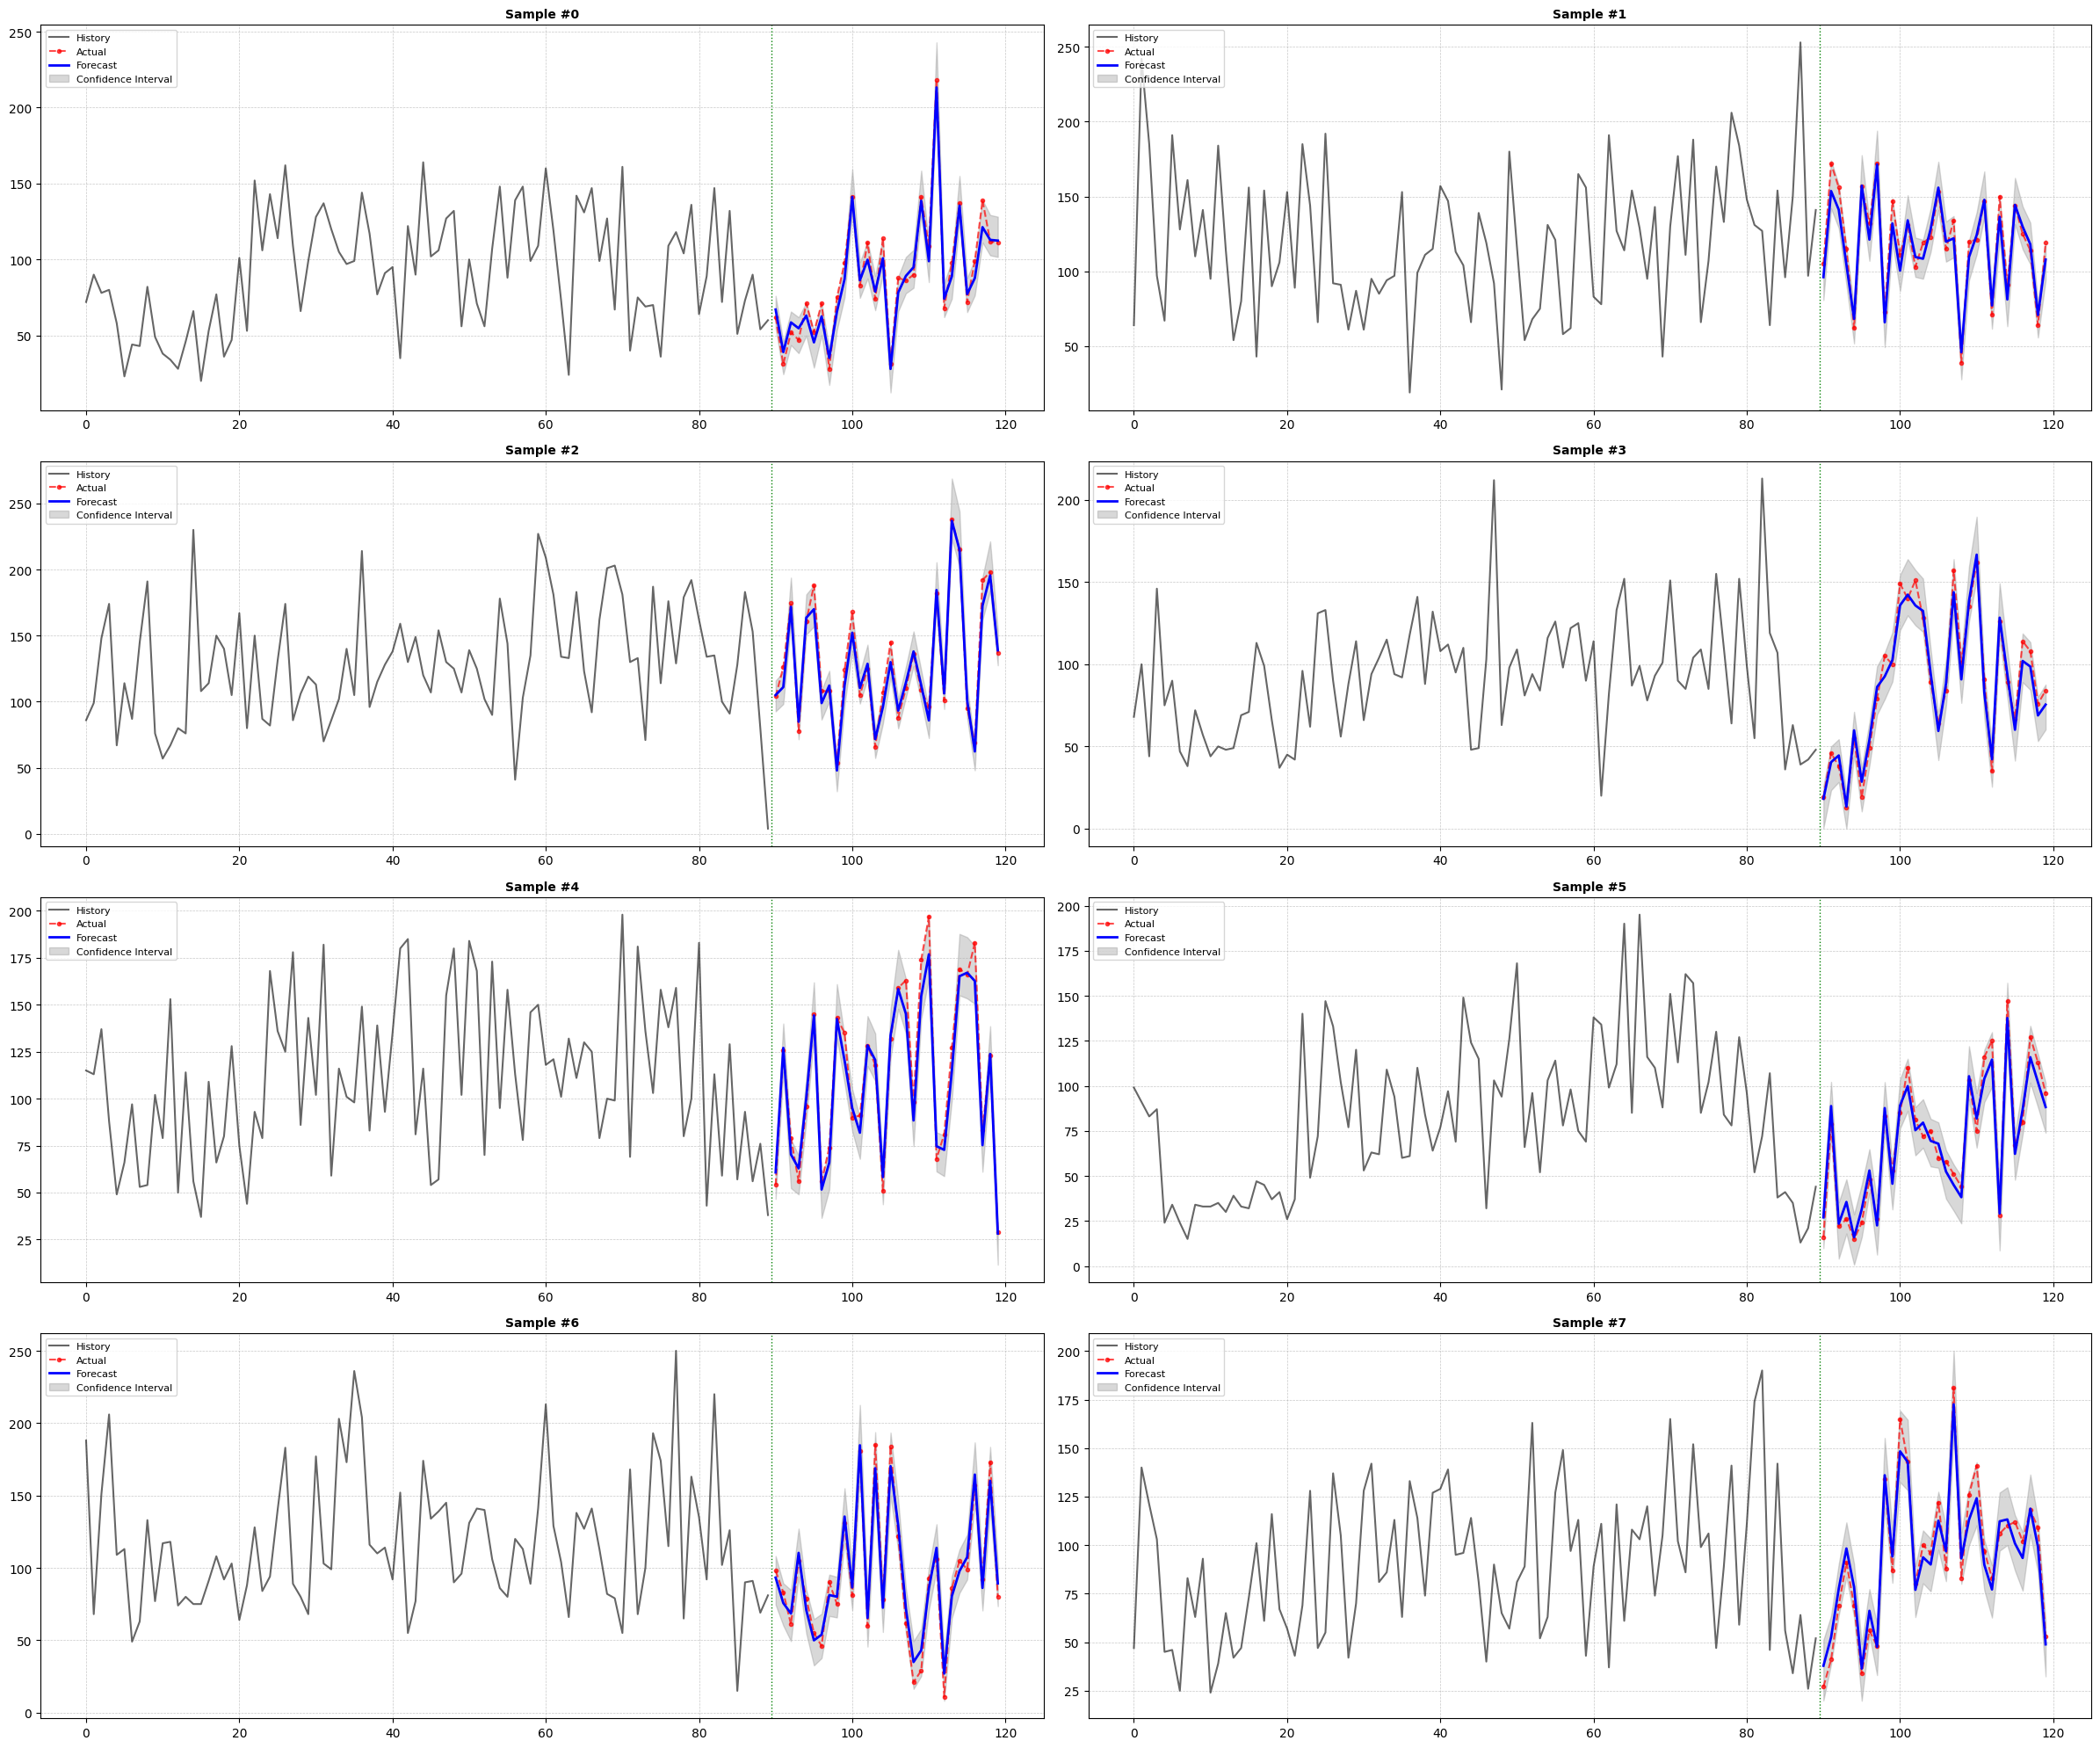

In [72]:
raw_predictions, x, *others = best_tft.predict(val_dataloader, mode="raw", return_x=True)

# Visualize predictions vs actuals for a sample from the validation set
def plot_prediction_sample(idx, x, raw_predictions, ax):
    encoder_target = x["encoder_target"][idx].cpu().numpy()
    decoder_target = x["decoder_target"][idx].cpu().numpy()
    
    # Extract the prediction sample for the given index
    prediction_sample = raw_predictions.prediction[idx].cpu().numpy()
    
    # Median prediction (0.5 quantile)
    pred_median = prediction_sample[:, 3]
    # 95% interval lower bound 
    pred_lower = prediction_sample[:, 0]
    # 95% inyerval upper bound
    pred_upper = prediction_sample[:, 6]
    
    # Calculate lengths of encoder and decoder targets for plotting
    enc_len = len(encoder_target)
    dec_len = len(decoder_target)

    # Define time steps for plotting  
    history_time_steps = range(enc_len)
    future_time_steps = range(enc_len, enc_len + dec_len)
    
    # History Data
    ax.plot(history_time_steps, encoder_target, color='black', alpha=0.6, label='History')
    
    # Future Actual Data
    ax.plot(future_time_steps, decoder_target, color='red', linestyle='--', marker='o', markersize=3, alpha=0.7, label='Actual')
    
    # Future Forecast
    ax.plot(future_time_steps, pred_median, color='blue', linewidth=2, label='Forecast')
    
    # Confidence Interval
    ax.fill_between(future_time_steps, pred_lower, pred_upper, color='gray', alpha=0.3, label='Confidence Interval')
    
    # Prediction Start Line
    ax.axvline(x=enc_len - 0.5, color='green', linestyle=':', linewidth=1)
    
    # Plot settings
    ax.set_title(f"Sample #{idx}", fontsize=10, fontweight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='upper left', fontsize=8, frameon=True)

num_samples_to_plot = 8  
ncols = 2               
nrows = math.ceil(num_samples_to_plot / ncols) 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 5 * nrows))
axes = axes.flatten() 

for i in range(num_samples_to_plot):
    if i >= len(x["encoder_target"]):
        break
        
    plot_prediction_sample(i, x, raw_predictions, axes[i])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x625 with 1 Axes>,
 'decoder_variables': <Figure size 700x425 with 1 Axes>}

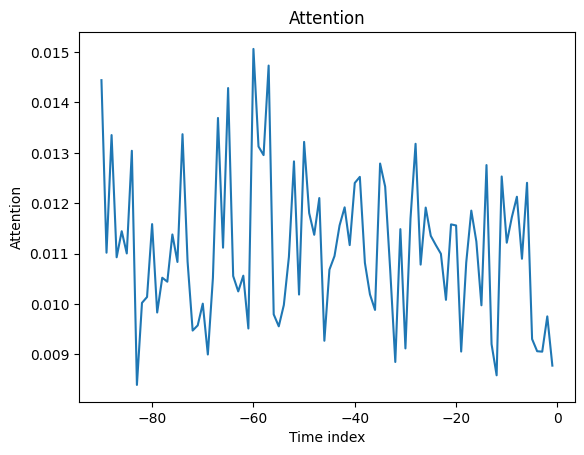

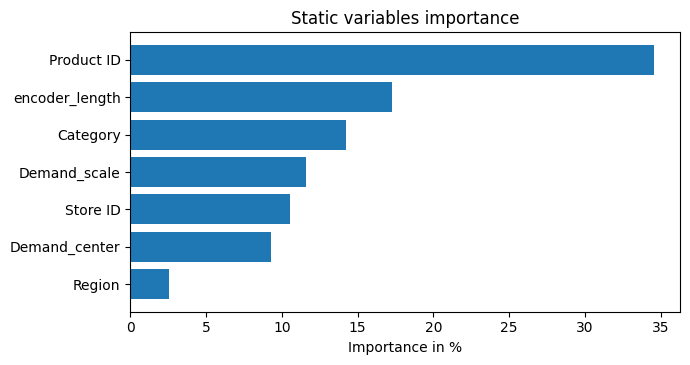

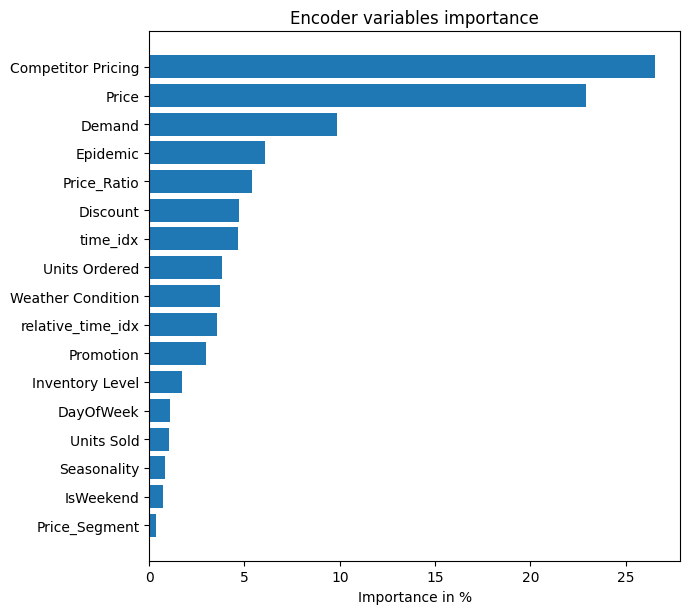

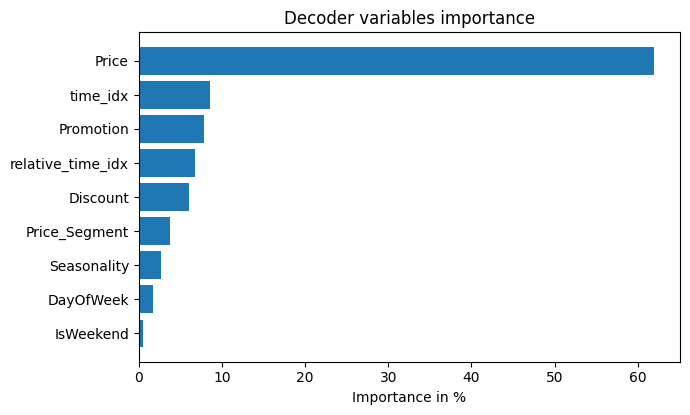

In [92]:
# Visualize feature importance using TFT's built-in interpretation method
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")

best_tft.plot_interpretation(interpretation)